# A SIMPLE STATISTICAL ANALYSIS OF ROBUSTNESS OF COVID-19 DATA FIT  

In this notebook I analyse data taken from the [European Center for Disease Prevention and Control](https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide) about the _ongoing global COVID-19 pandemic_ .

I will focus my analysis on the **total number of observed cases in China, Italy, South Korea, Japan and France** in order to try to comprehend better the stability and the forecasting power of a simple logistic (and to lesser extend exponential) function while the **pandemic is still ongoing**. 

Moreover, I will try to understand if we can gain some insight on the **duration of the quarantines, which were put in place in all the countries analyzed here.**

Due to the sensitivity and importance of this topic, this analysis should be taken as not more than as an intellectual exercise about the current state of the global pandemic. 

I will, in fact, try to compare data among different countries which have been collected in very hazardous and complex situations and they probably contain biases and errors. 

To mitigate this, I will **renormalize data at the country level, before any comparison** : this is probably not enough but it is the most that I was able with available data (and any suggestion on how to improved this is more than welcomed). 

Further analysis will be needed to asses the validity of this and other studies and I am sure that the scientific community and society at large will tackle them, once the pandemic will be more under control.


From a more technical point of view, I used in this analysis tools and techniques that should be familiar to most people with a background in data science/analysis and any question/comment is (again) more than welcomed.

Due to my personal background, some of this analysis will focus on Italy but it should generic enough to be easily reproducible in other countries. 

## Analysis of fit stability for Italy and China 

In this section I will analysis the **time stability of fits on the observed cases of COVID-19 in Italy and China**. 
In order to that, I define here some function that will be handy for future analysis: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lmfit.models import ExponentialModel
from lmfit.models import StepModel

def fit_and_obtain_parameters(x,y,model):
    """
    Just a wrapper of lmfit fit to then obtain the best fit values. 
    """
    
    params = model.guess(y, x=x)
    result = model.fit(y, params, x=x)
    
    values = np.array([])
    std_err = np.array([])
    
    for p in result.params:
        values = np.append(values,result.params[p].value)
        std_err = np.append(std_err,result.params[p].stderr)
        
        
    return values, std_err, result.redchi


def return_parameters_over_time(x,y,model,position_param=0,min_days=16):
    """
    A function which performs a fit per day (after min_days days)
    and returns the value and the standard error of the
    parameter in position position_param. 
    """
    
    values_param_per_day =  np.array([])
    stderr_param_per_day =  np.array([])
    rchi_per_day = np.array([])
    
    for j in range(min_days,len(y)):
        
        values, stds, red_chi = fit_and_obtain_parameters(x.head(j),
                                                 y.head(j),
                                                 model)
        
        values_param_per_day = np.append(values_param_per_day,values[position_param])
        stderr_param_per_day = np.append(stderr_param_per_day,stds[position_param])
        rchi_per_day = np.append(rchi_per_day, red_chi)
        
    
    return values_param_per_day, stderr_param_per_day, rchi_per_day

import scipy



def rate_estimate(x,n_bay_0=0,n_bay_1=0):
    rate = scipy.stats.beta.ppf(0.5 , 
                                x[0]+n_bay_0+1, 
                               (x[1]+n_bay_1)-(x[0]+n_bay_0)+1)
    return rate

def confidence_beta_distribution(x, alpha=0.90, n_bay_0=0,n_bay_1=0):
    lower = scipy.stats.beta.ppf((1.0 - alpha)/2.0 ,
                                x[0]+n_bay_0+1, 
                               (x[1]+n_bay_1)-(x[0]+n_bay_0)+1)
    upper = scipy.stats.beta.ppf((1.0 + alpha)/2.0 ,
                                x[0]+n_bay_0+1, 
                               (x[1]+n_bay_1)-(x[0]+n_bay_0)+1)
    return  upper - lower 


def create_df_country(df_world, country_name,n_bay_0=0,n_bay_1=0):
    """
    Create dataframe for country and order by days after first case. 
    """
    df_country = df_world[df_world["countriesAndTerritories"] == country_name]
    df_country["date_time_date"] = pd.to_datetime(df_country[["year", "month","day"]])
    
    df_country = df_country.sort_values("date_time_date",ascending=True)    
    df_country["Total_cumulative_Cases"] = df_country["cases"].cumsum()
    df_country["Total_cumulative_Deaths"] = df_country["deaths"].cumsum()
    df_country["mortality_rate"] = df_country[["Total_cumulative_Deaths", "Total_cumulative_Cases"]].apply(rate_estimate, axis=1)
    df_country["mortality_error"] = df_country[["Total_cumulative_Deaths", "Total_cumulative_Cases"]].apply(confidence_beta_distribution, axis=1)
    df_country["mortality_relative_error"] = df_country["mortality_error"] / df_country["mortality_rate"]
    df_country["mortality_rate_bayes"] = df_country[["Total_cumulative_Deaths", "Total_cumulative_Cases"]].apply(rate_estimate,
                                                                                                       axis=1,
                                                                                                       n_bay_0=n_bay_0,
                                                                                                       n_bay_1=n_bay_1)
    df_country["mortality_error_bayes"] = df_country[["Total_cumulative_Deaths", "Total_cumulative_Cases"]].apply(confidence_beta_distribution,
                                                                                                        axis=1,
                                                                                                        n_bay_0=n_bay_0,
                                                                                                        n_bay_1=n_bay_1)
    
    df_country = df_country[df_country["Total_cumulative_Cases"]>0]
    first_day = df_country["date_time_date"].iloc[0]
    df_country["number_days"] =  [abs((day - first_day).days) for day in df_country["date_time_date"]]
    
    return df_country

In [2]:
plt.rcParams['figure.figsize'] = [10, 8] #larger plots

As I have said in the previous section, the data are taken from European Center for Disease Prevention and Control and have to be _manually downloaded_ (at least as of today, 22/03/2020).

More refined data about the Italian situation can be found on the [great Github of the Protezione Civile](https://github.com/pcm-dpc/COVID-19) which is update daily and there exists also a [Kaggle competition with global data](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). 
However, I personally find data from ECPC more handy for cross-country comparison and that is why I use them here.

After loading the dataset, and I have create a dataframe for each country taken data starting from the **first day in which a case was observed in each one of these countries,** which roughly corresponds to beginning of the epidemy in the country of interest. 

Moreover, in order to able to compare results among different countries, I have created, for each dataset, a column called "number_days" which represents the days passed from the first case.  

In [3]:
df_world = pd.read_csv("COVID-19-geographic-disbtribution-worldwide-2020-04-03.csv")
df_world.head(5)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,4/3/2020,3,4,2020,43,0,Afghanistan,AF,AFG,37172386.0
1,4/2/2020,2,4,2020,26,0,Afghanistan,AF,AFG,37172386.0
2,4/1/2020,1,4,2020,25,0,Afghanistan,AF,AFG,37172386.0
3,3/31/2020,31,3,2020,27,0,Afghanistan,AF,AFG,37172386.0
4,3/30/2020,30,3,2020,8,1,Afghanistan,AF,AFG,37172386.0


In [4]:
top20_countries = df_world.groupby("countriesAndTerritories").sum().sort_values("cases", ascending=False).reset_index().head(20)["countriesAndTerritories"].tolist()

n_world_top20_cases = df_world[df_world["countriesAndTerritories"].isin(top20_countries)]["cases"].sum()
n_world_top20_death = df_world[df_world["countriesAndTerritories"].isin(top20_countries)]["deaths"].sum()

dict_of_df = {}

for country in top20_countries:
    
    df = create_df_country(df_world, country, n_bay_0=n_world_top20_death,n_bay_1=n_world_top20_cases)  

    dict_of_df[country] = df   

/home/luca.albertorizzo/venv/Prediction_conversion_multi_channel/lib/python3.5/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/luca.albertorizzo/venv/Prediction_conversion_multi_channel/lib/python3.5/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/luca.albertorizzo/venv/Prediction_conversion_multi_channel/lib/python3.5/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [5]:
df_world_italy = dict_of_df["Italy"] #defining dataset for Italy and China for convi
df_world_china = dict_of_df["China"] 

### Exponential vs Logistic fit for Italy and China

As a starting point, we can ask ourselves a simple question for Italy:

- as of today 22/03/2020, is the number of total observed cases $N_c$ still growing **in exponential fashion or is its growth more similar to a logistic one**? 

In order to answer this question, it might be useful to give a quick reminder of the definition and some proprieties of the two functions. 

If the $N_c(t)$ follows an exponential we have: 
\begin{equation}
N^e_c(t) = C e^{-t / \tau}
\end{equation}

with $t$ the number of days after the first observed case and $\tau$ the "decay time", which will be negative for us in order to model an exponential growth. 

On the other hand, if $N_c(t)$ follows has a logistic growth:
\begin{equation}
N^L_c(t) =  \frac{A}{1+e^{(t-\mu)/\sigma}}
\end{equation}
where A is the total **observed number of cases over the whole pandemic**, a parameter which might be of particular interest for our analysis.

As of **22/01/2020** data for Italy look like: 

'\nplt.title("Totale casi in Italia")\nplt.xlabel("Giorni dal primo caso")\nplt.savefig("fit_italia_exp_log.png")\n'

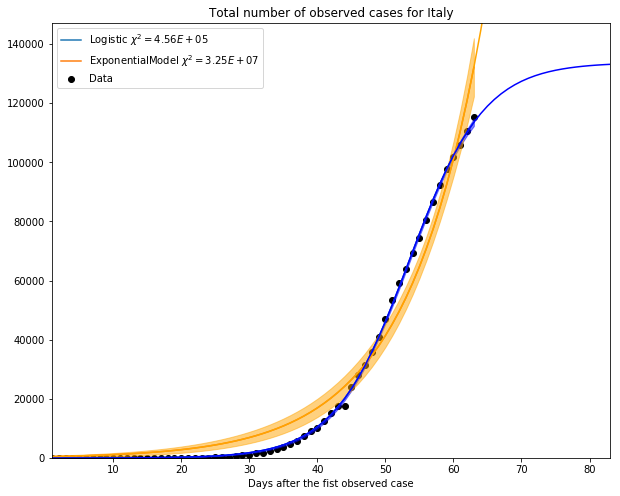

In [6]:
model_exp = ExponentialModel()
params_exp = model_exp.guess(df_world_italy["Total_cumulative_Cases"], x=df_world_italy["number_days"])
result_exp = model_exp.fit(df_world_italy["Total_cumulative_Cases"], params_exp, x=df_world_italy["number_days"])

model_log = StepModel(form='logistic')
params_log = model_log.guess(df_world_italy["Total_cumulative_Cases"], x=df_world_italy["number_days"])
result_log = model_log.fit(df_world_italy["Total_cumulative_Cases"], params_log, x=df_world_italy["number_days"])


tanti_giorni = np.array([i for i in range(1,len(df_world_italy)+20)])

plt.plot(df_world_italy["number_days"],
         result_log.best_fit,
         label="Logistic $\chi^2 = {:.2E}$".format(result_log.redchi))

plt.plot(df_world_italy["number_days"],
         result_exp.best_fit,
         label="ExponentialModel $\chi^2 = {:.2E}$".format(result_exp.redchi))

plt.scatter(df_world_italy["number_days"],
            df_world_italy["Total_cumulative_Cases"], 
            marker = 'o',color='black',
           label ="Data")

"""

plt.plot(df_world_italy["number_days"],
         result_log.best_fit,
         label="Curva logistica")

plt.plot(df_world_italy["number_days"],
         result_exp.best_fit,
         label="Curva esponenziale")

plt.scatter(df_world_italy["number_days"],
            df_world_italy["Total_cumulative_Cases"], 
            marker = 'o',color='black',
           label ="Dati")
"""

dely_log = result_log.eval_uncertainty(x=df_world_italy["number_days"],sigma=3)

plt.fill_between(df_world_italy["number_days"], 
                 result_log.best_fit-dely_log,
                 result_log.best_fit+dely_log, 
                 color='b',
                 alpha=0.5)

dely_exp = result_exp.eval_uncertainty(x=df_world_italy["number_days"],sigma=3)

plt.fill_between(df_world_italy["number_days"], 
                 result_exp.best_fit-dely_exp,
                 result_exp.best_fit+dely_exp, 
                 color='orange',
                 alpha=0.5)

params_exp = model_exp.make_params(decay = result_exp.params["decay"].value, 
                            amplitude = result_exp.params["amplitude"].value)

plt.plot(tanti_giorni, result_exp.eval(params_exp, x=tanti_giorni),color='orange')


params_log = model_log.make_params(sigma = result_log.params["sigma"].value, 
                                   amplitude = result_log.params["amplitude"].value,
                                   center = result_log.params["center"].value) 


#params_log = model_log.make_params(result_log.params) 

plt.plot(tanti_giorni, result_log.eval(params_log, x=tanti_giorni),color='b')

plt.ylim(100,result_log.params["amplitude"].value*1.1)
plt.xlim(1,tanti_giorni[-1])

plt.title("Total number of observed cases for Italy")
plt.xlabel("Days after the fist observed case")
plt.legend()
"""
plt.title("Totale casi in Italia")
plt.xlabel("Giorni dal primo caso")
plt.savefig("fit_italia_exp_log.png")
"""

and the fit seem to **slightly** prefer a Logistic trend instead of an exponential one (note the values of the $\chi^2$ in the legend).

However almost all data points fall inside the $3-\sigma$ error bars of both the fitted functions and so very little can be said about the which **function would be better at forecasting new data**, due to the quite fast growth of the number observed of cases in Italy. 

Armed with fits, we could ask ourselves questions about the time stability of the Logistic fit. In particular, I think it is beneficial to ask the question: 
- how much a the fit of 7 days ago would be able to **forecast the observed number of cases in last 7 days**? 

'\nplt.title("Totale casi in Italia")\nplt.xlabel("Giorni dal primo caso")\nplt.savefig("fit_italia_log_logsett.png")\n'

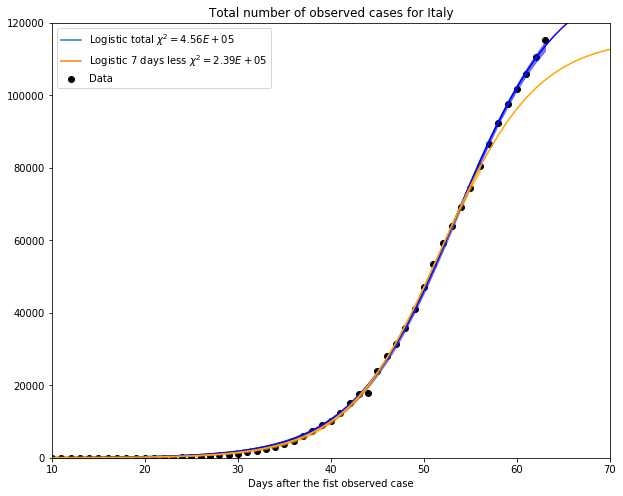

In [7]:
model_log = StepModel(form='logistic')
params_log = model_log.guess(df_world_italy["Total_cumulative_Cases"], x=df_world_italy["number_days"])

result_log = model_log.fit(df_world_italy["Total_cumulative_Cases"], params_log, x=df_world_italy["number_days"])

n_less = 7 

n_days = len(df_world_italy) - n_less 

params_log_5days_ago = model_log.guess(df_world_italy["Total_cumulative_Cases"].head(n_days), 
                                       x=df_world_italy["number_days"].head(n_days))


result_log_5days_ago = model_log.fit(df_world_italy["Total_cumulative_Cases"].head(n_days), 
                                     params_log, 
                                     x=df_world_italy["number_days"].head(n_days))

plt.plot(df_world_italy["number_days"],
         result_log.best_fit,
         label="Logistic total $\chi^2 = {:.2E}$".format(result_log.redchi))

plt.plot(df_world_italy["number_days"].head(n_days),
         result_log_5days_ago.best_fit,
         label="Logistic {} days less $\chi^2 = {:.2E}$".format(n_less, result_log_5days_ago.redchi))

plt.scatter(df_world_italy["number_days"],
            df_world_italy["Total_cumulative_Cases"], 
            marker = 'o',color='black',
           label = 'Data')

"""

plt.plot(df_world_italy["number_days"],
         result_log.best_fit,
         label="Logistica con dati fino al 22/03")

plt.plot(df_world_italy["number_days"].head(n_days),
         result_log_5days_ago.best_fit,
         label="Logistica con dati fino al 15/03")

plt.scatter(df_world_italy["number_days"],
            df_world_italy["Total_cumulative_Cases"], 
            marker = 'o',color='black',
           label = 'Dati')
"""

dely_log = result_log.eval_uncertainty(x=df_world_italy["number_days"],sigma=3)

plt.fill_between(df_world_italy["number_days"], 
                 result_log.best_fit-dely_log,
                 result_log.best_fit+dely_log, 
                 color='b',
                 alpha=0.5)


dely_log_5days_ago = result_log_5days_ago.eval_uncertainty(x=df_world_italy["number_days"].head(n_days),sigma=3)

plt.fill_between(df_world_italy["number_days"].head(n_days), 
                 result_log_5days_ago.best_fit-dely_log_5days_ago,
                 result_log_5days_ago.best_fit+dely_log_5days_ago, 
                 color='orange',
                 alpha=0.5)


params_log = model_log.make_params(sigma = result_log.params["sigma"].value, 
                                   amplitude = result_log.params["amplitude"].value,
                                   center = result_log.params["center"].value) 

plt.plot(tanti_giorni, result_log.eval(params_log, x=tanti_giorni),color='b')


params_log_5days_ago = model_log.make_params(sigma = result_log_5days_ago.params["sigma"].value, 
                                   amplitude = result_log_5days_ago.params["amplitude"].value,
                                   center = result_log_5days_ago.params["center"].value) 

plt.plot(tanti_giorni, result_log_5days_ago.eval(params_log_5days_ago, x=tanti_giorni),color='orange')

plt.ylim(0,120000)
plt.xlim(10,70)
plt.legend()

plt.title("Total number of observed cases for Italy")
plt.xlabel("Days after the fist observed case")
"""
plt.title("Totale casi in Italia")
plt.xlabel("Giorni dal primo caso")
plt.savefig("fit_italia_log_logsett.png")
"""


As we can see from the plot above, the fit is very unstable and the parameters change dramatically.
This , combined with the fact the fit singularly show a similar $ \chi^2$, shows that the **forecasting power of a logistic function during an ongoing pandemic might be very limited** and particular care should be taken when using it. 

So, should we abandon the Logistic function as a candidate to describe this growth?

No, not entirely at least.In fact, the logistic function does a discrete job in describing and forecasting values, **once that the spread of the virus is more under control and fit starts to stabilize**. 

This can be shown by fitting the Chinese data using all available data and comparing them to a fit made by using all data from the beginning up to the 20 days ago: 

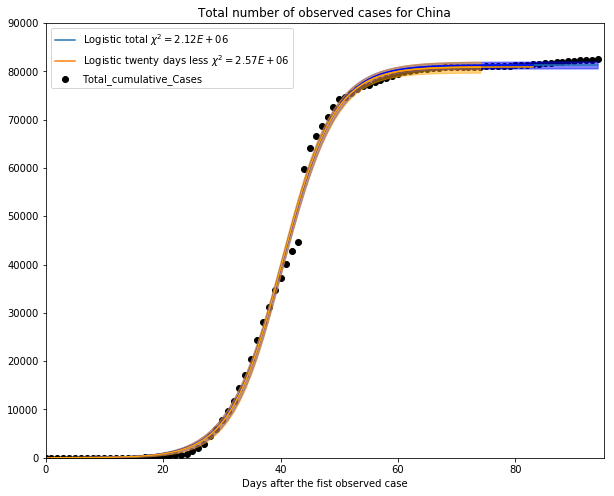

In [8]:
model_log = StepModel(form='logistic')
params_log = model_log.guess(df_world_china["Total_cumulative_Cases"], x=df_world_china["number_days"])

result_log = model_log.fit(df_world_china["Total_cumulative_Cases"], params_log, x=df_world_china["number_days"])

n_days = len(df_world_china) - 20

params_log_5days_ago = model_log.guess(df_world_china["Total_cumulative_Cases"].head(n_days), 
                                       x=df_world_china["number_days"].head(n_days))


result_log_5days_ago = model_log.fit(df_world_china["Total_cumulative_Cases"].head(n_days), 
                                     params_log, 
                                     x=df_world_china["number_days"].head(n_days))

plt.plot(df_world_china["number_days"],
         result_log.best_fit,
         label="Logistic total $\chi^2 = {:.2E}$".format(result_log.redchi))

plt.plot(df_world_china["number_days"].head(n_days),
         result_log_5days_ago.best_fit,
         label="Logistic twenty days less $\chi^2 = {:.2E}$".format(result_log_5days_ago.redchi))


plt.scatter(df_world_china["number_days"],
            df_world_china["Total_cumulative_Cases"], 
            marker = 'o',color='black')


dely_log = result_log.eval_uncertainty(x=df_world_china["number_days"],sigma=3)

plt.fill_between(df_world_china["number_days"], 
                 result_log.best_fit-dely_log,
                 result_log.best_fit+dely_log, 
                 color='b',
                 alpha=0.5)


dely_log_5days_ago = result_log_5days_ago.eval_uncertainty(x=df_world_china["number_days"].head(n_days),sigma=3)

plt.fill_between(df_world_china["number_days"].head(n_days), 
                 result_log_5days_ago.best_fit-dely_log_5days_ago,
                 result_log_5days_ago.best_fit+dely_log_5days_ago, 
                 color='orange',
                 alpha=0.5)


params_log = model_log.make_params(sigma = result_log.params["sigma"].value, 
                                   amplitude = result_log.params["amplitude"].value,
                                   center = result_log.params["center"].value) 

plt.plot(tanti_giorni, result_log.eval(params_log, x=tanti_giorni),color='b')


params_log_5days_ago = model_log.make_params(sigma = result_log_5days_ago.params["sigma"].value, 
                                   amplitude = result_log_5days_ago.params["amplitude"].value,
                                   center = result_log_5days_ago.params["center"].value) 

plt.plot(tanti_giorni, result_log_5days_ago.eval(params_log_5days_ago, x=tanti_giorni),color='orange')

plt.ylim(0,90000)
plt.xlim(0,95)
plt.title("Total number of observed cases for China")
plt.xlabel("Days after the fist observed case")
plt.legend()

As we can see from above, **the fit is much more stable and the fit done 20 days ago does a good job in forecasting values in last 20 days.** 

To summarize, as long as the spread of **the virus is too fast, the fits using Logistic functions are not stable enough to draw any conclusion on future data. However, once the spread starts to slow down, the fit becomes stable and does a good job in forecasting future values.** 


### A (TENTATIVE) COMPARISON AMONG COUNTRIES TO GIVE AN ESTIMATE OF THE DURATION OF THE QUARANTINE 

As advised from the WHO, the quarantine has been taken place in several countries in order to try to slow down the growth total number of cases and therefore minimize the damage of the ongoing pandemics.  

Since the quarantine has a strong effect on the population and the economics of the countries, it would be beneficial to have a rough estimate of the its duration. This is no easy task, since different countries acted in different ways at different paces due to a variety of reasons. Moreover there exist only one known case were the quarantine was (at least partially) lifted up, namely China, and so any method to estimate of the duration of the quarantine cannot be properly verified. 

In any case, I will try to understand if I can use **some of the findings about the stability of the Logistic fits to to gain some insight of the duration of the quarantine.** 

To achieve this, I have runt, for each country of interest, several fits of the Logistic function using every time data **from the first day in which COVID-19 was first observed ($t_0$) up to day $t$**, with $t$ that runs from $t_0$ up to today. 

In particular, this procedure will give us for each day the estimated total number of infected people  for each country (see plot below), which can be seen as a function of the (cumulative) time, called here $A(t)$.

I will argue here that we can gain some insight about the duration of the quarantine by studying $A(t)$, once that the latter is properly renormalized. (see below)


Below I run the model described here, where I have excluded the first _min_days_ days where the fit of Logistic functions was too noisy.

Text(0, 0.5, '$A(t) / A(t_O)$')

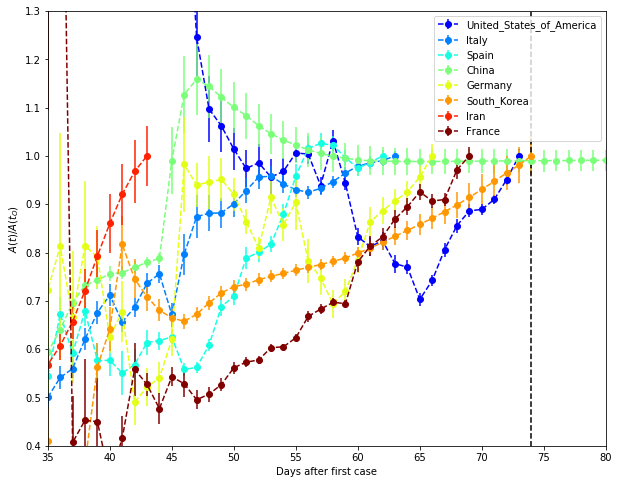

In [12]:
countries = ['United_States_of_America', 'Italy', 
             'Spain', 'China', 
             'Germany', 'South_Korea',
             'Iran','France']

cmap = plt.cm.get_cmap("jet", len(countries)+1)
i=0 

model_log = StepModel(form='logistic')

params_log = model_log.guess(df_world_china["Total_cumulative_Cases"], 
                             x=df_world_china["number_days"]) #using China as a starting point for minization of parameters



for country in countries:
    
    i+= 1 
    
    df = dict_of_df[country]
    values_name = country + '_values_amplitude_per_day'
    stderr_name = country + '_stderr_amplitude_per_day'
    red_chi_name = country + '_red_chi_per_day'
    
    values_amplitude_per_day, stderr_amplitude_per_day, red_chi_log = return_parameters_over_time(
                                                df["number_days"],
                                                df["Total_cumulative_Cases"],
                                                model_log,
                                                position_param=0,
                                                min_days=30)
    
    dict_of_df[values_name] = values_amplitude_per_day
    dict_of_df[stderr_name] = stderr_amplitude_per_day
    dict_of_df[red_chi_name] = red_chi_log
       
    relative_error = stderr_amplitude_per_day / values_amplitude_per_day
    
    filter_error = relative_error < 1.0 #excludying values that have error that are "too high"
    
    plt.errorbar(df["number_days"][30:len(df)+1][filter_error], 
             values_amplitude_per_day[filter_error] / values_amplitude_per_day[-1],
             linestyle = '--',
             marker = 'o',
             color = cmap(i),
             yerr = stderr_amplitude_per_day[filter_error] / values_amplitude_per_day[-1] ,
             ecolor = cmap(i),
             label=country)
    
    
plt.ylim(0.4,1.3)
plt.xlim(35,80)
plt.vlines(74,-10,30, linestyles='--') #"end of quarantine" in China
plt.legend()
plt.xlabel("Days after first case")
plt.ylabel("$A(t) / A(t_O)$")

As mentioned below, I have plotted $A(t) / A(t=t_N)$, i.e. the **estimated total number of cases as a function of time renormalized over its value today  A(t=t_N)**. 

In the plot the black dashed line represents the day where the Chinese government started to lift some of the quarantine's restrictions. This corresponds to roughly **14 days before the ratio $A(t) / A(t=t_0)$ became stable**, due lack of new cases. 

This suggest that studying the curve $A(t) / A(t=t_0)$  (and its stability) might give some insight on the duration of the quarantine. 

Unfortunately, the ratios $A(t) / A(t=t_0)$ for most of the countries still show a growing trend and in the very optimistic scenario where the ratio stabilizes during the next days, I would **not expect the quarantine to end in the next 15/20 days.**

*any comment on this assumption is more than welcomed. 


# CONCLUSIONS

In this notebook I have studied some of the data available on the ongoing global pandemic of COVID-19. 

In particular I have focused on the time trends of the total number of observed infected people in China, Italy, Japan, South Korea and France. 

I have showed that, as of today 22/03/2020, the Italian data seems to prefer a Logistic model but with huge instability and little forecasting power, due to the ongoing spread of the virus. On the other hand in China, where the epidemic is more under control, the fit with a Logistic function is stable and has a good forecasting power.

This inspired me in studying the behavior of $A(t) / A(t=t_0)$ for several countries in order to give some insight on the duration of the quarantine. Findings are still quite weak but they suggest for European countries as of today 03/04/2020 the quarantine won't be lifted before the 15/20 days, even in the best case scenario.

In any case, I argue here that it would be beneficial to study more in depth $A(t) / A(t=t_0)$, in particular its forecasting power but more analysis are probably needed. 

These findings are still "weak" at the moment for a variety of reasons that I have tried to highlight here but, as I have mentioned before, **any comment/suggestion is more than welcomed.**